# Reinforcement Learning
This is more generic approach to RL than the OpenAI gym model we will use. Pay attion to how these are similiar and different as we work through both approaches.
Examples will include:<br>
- __Environment__: The Environment section will have a Environment class. The Environment class will generally have these elements:
    - *Variables*
        - action_space: A list of all possible actions in the environment.
        - state_space: A list of all possible states in the environment.
        - state: Current state in the environment.
    - *Methods*
        - step: Takes a step with given action and return (next_state, reward, done, info)
        - reset: Resets the environment and returns the initial state.
- __Agent__: The Agent section will have the agent that can interact with the environment. The Agent class will generally have these elements:
    - *Variables*
        - name: A string that acts as a name of the agent.
    - *Methods*
        - get_action: Get action based on the agent's policy.
        - update: Update parameters based on (state, action, next_state, reward, done).
        - reset: Resets the agent back to initial values, before interacting with the environment.
- __Plot__: Plot section will have the plots that resemble the figures in the book.

Examples adapted from Reinforcement Learning: An Introduction (Sutton and Barto, 2018; MIT Press, Second Edition) and https://github.com/seungjaeryanlee/sutton-barto-notebooks

## General Setup
We're going to try to do as much by hand as possible to show the concepts.

## Toy Example

### Defining things

In [1]:
from enum import IntEnum
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
class Action(IntEnum):
    UP = 1
    DOWN = -1

In [3]:
class Environment:
    
    action_space = list(Action)
    state_space = [0, 1, 2, 3, 4, 5, 6]
    
    def __init__(self):
        self.state = 3
        self.reward = 0

    def step(self, action):
        done = self.is_done()
        if self.state == 0:
            self.reward += 1
        elif self.state == 6:
            self.reward += 10
        else:
            self.state += action
        info = {}
        return self.state, self.reward , done, info

    def reset(self):
        self.state = 3
        self.reward = 0

    def is_done(self):
        return self.state == 0 or self.state == 6

In [4]:
class RandomAgent:

    def __init__(self, name):
        self.name = name

    def get_action(self):
        random_choice = random.randint(0, 1)
        if (random_choice == 0):
            return Action.UP
        else:
            return Action.DOWN
    
    def update(self, state, action, reward, next_state, done):
        # For training
        pass

### Using these classes

In [5]:
basic_env = Environment()
rl_agent = RandomAgent('Random')
for _ in range(10):
    basic_env.reset()
    done = False
    while not done:
        action = rl_agent.get_action()
        obs, reward, done, info = basic_env.step(action)
        if done:
            print('Episode Reward: {}'.format(reward))

Episode Reward: 1
Episode Reward: 10
Episode Reward: 1
Episode Reward: 10
Episode Reward: 1
Episode Reward: 10
Episode Reward: 1
Episode Reward: 1
Episode Reward: 1
Episode Reward: 10


### Let's use a better actor than random!

In [6]:
class StochasticAgent:

    def __init__(self, probability_up):
        self.p_up = probability_up

    def get_action(self):
        if np.random.random() < self.p_up:
            return Action.UP
        else:
            return Action.DOWN

### Plotting results (vary prob of going up via epsilon greedy)

In [7]:
def plot(epsilon=0.1, xs=np.arange(0.01, 1, 0.01).tolist(), n_episodes=1000):
    x_epsilon_down = epsilon / 2
    x_epsilon_up = 1 - epsilon / 2
    xs.extend([x_epsilon_down, x_epsilon_up])
    xs.sort()
    i_epsilon_up = xs.index(x_epsilon_up)
    i_epsilon_down = xs.index(x_epsilon_down)

    average_rewards = []
    for p_up in xs:
        env = Environment()
        agent = StochasticAgent(p_up)

        total_reward = 0
        for _ in range(n_episodes):
            env.reset()
            total_episode_reward = 0
            done = False
            while not done:
                action = agent.get_action()
                _, reward, done, _ = env.step(action)
                total_episode_reward += reward

            total_reward += total_episode_reward

        average_rewards.append(total_reward / n_episodes)

    max_pt = (xs[np.argmax(average_rewards)], np.max(average_rewards))
    epsilon_down_pt = (xs[i_epsilon_down], average_rewards[i_epsilon_down])
    epsilon_up_pt = (xs[i_epsilon_up], average_rewards[i_epsilon_up])

    print('Optimal Policy Probability: {:.2f}'.format(max_pt[0]))
    print('Optimal Policy Reward     : {:.2f}'.format(max_pt[1]))
    print('Epsilon Down Reward       : {:.2f}'.format(epsilon_down_pt[1]))
    print('Epsilon UP Reward      : {:.2f}'.format(epsilon_up_pt[1]))
    
    plt.plot(xs, average_rewards)

    plt.xlim(0, 1)
    plt.xlabel('Probability of Selecting UP')
    plt.ylim(0, 11)
    plt.ylabel('Reward')
    plt.show()

Optimal Policy Probability: 0.94
Optimal Policy Reward     : 10.00
Epsilon Down Reward       : 1.01
Epsilon UP Reward      : 10.00


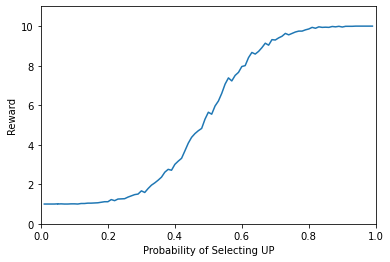

In [8]:
plot()

## Epsilon Greedy

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def argmax_all(list_):
    """
    Returns all argmax of given list in a list. Different from np.argmax which 
    returns first instance only.
    """
    return np.argwhere(list_ == list_.max()).flatten()

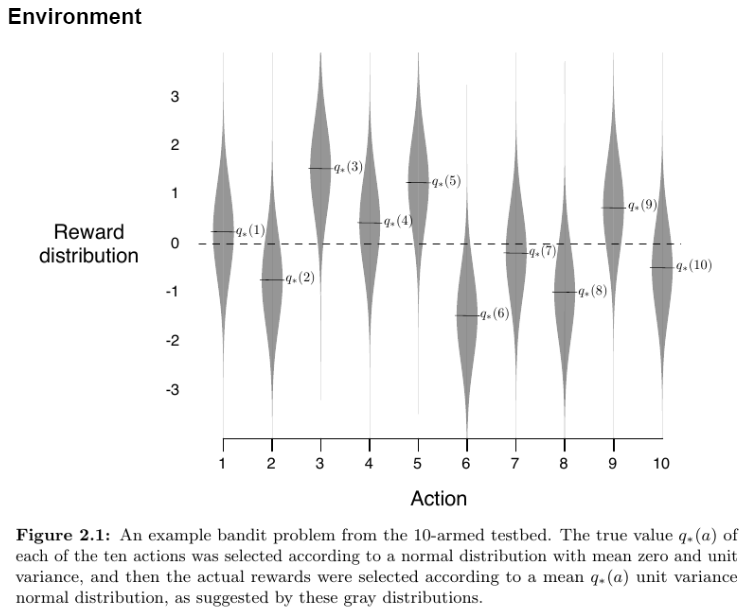

In [11]:
class Environment:
    """
    The 10-armed Testbed environment shown in Figure 2.1 of Sutton and Barto
    """
    def __init__(self, n_actions=10):
        self.action_space = [i for i in range(n_actions)]
        self.distributions = []
        for _ in range(n_actions):
            mean = np.random.normal(0, 1)
            stddev = 1
            self.distributions.append((mean, stddev))

        self.optimal_action = np.argmax([d[0] for d in self.distributions])

    def step(self, action):
        """
        Returns the reward of the given action.
        """
        mean, stddev = self.distributions[action]
        reward = np.random.normal(loc=mean, scale=stddev)
        return reward

    def reset(self):
        """
        Reset the reward distributions of the environment.
        """
        self.distributions = []
        for _ in range(len(self.action_space)):
            mean = np.random.normal(0, 1)
            stddev = 1
            self.distributions.append((mean, stddev))

        self.optimal_action = np.argmax([d[0] for d in self.distributions])

In [12]:
class Agent:
    """
    An e-greedy agent.
    """

    def __init__(self, action_space, epsilon=0):
        self.action_space = action_space
        self.q = np.zeros(len(action_space))
        self.action_counts = np.zeros(len(action_space), dtype=int)
        self.epsilon = epsilon

    def get_action(self):
        """
        Choose action with epsilon-greedy policy.
        """
        if random.random() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            return np.random.choice(argmax_all(self.q))

    def update_q(self, action, reward):
        """
        Update appropriate Q value with given action and reward.
        """
        self.action_counts[action] += 1
        self.q[action] += (reward - self.q[action]) / \
            self.action_counts[action]

    def reset(self):
        """
        Reset agent's Q values to 0.
        """
        self.q = np.zeros(len(self.action_space))
        self.sum_rewards = np.zeros(len(self.action_space))
        self.action_counts = np.zeros(len(self.action_space), dtype=int)

In [13]:
def run(env, agent, n_steps=1000):
    """
    Take actions on the bandit environment. This is called a "run".
    """
    actions = np.zeros(n_steps, dtype=int)
    rewards = np.zeros(n_steps)
    for i in range(n_steps):
        actions[i] = agent.get_action()
        rewards[i] = env.step(actions[i])
        agent.update_q(actions[i], rewards[i])

    return (actions, rewards)

In [14]:
def runs(env, agent, n_runs=2000, n_steps=1000):
    """
    Perform multiple runs on given environment and agent, resetting
    environment and agent after every run. Resetting environment
    changes the actions' reward distributions, and resetting the
    agent resets its Q values.
    """
    sum_rewards = np.zeros(n_steps)
    optimal_action_counts = np.zeros(n_steps)

    for i in range(n_runs):
        env.reset()
        agent.reset()

        actions, rewards = run(env, agent, n_steps)

        sum_rewards = np.add(sum_rewards, rewards)

        for step, action in enumerate(actions):
            if action == env.optimal_action:
                optimal_action_counts[step] += 1

    return sum_rewards / n_steps, optimal_action_counts / n_runs

In [15]:
def plot_average_rewards(epsilons, n_runs, n_steps):
    """
    Plot a graph of average rewards throughout runs for agents specified by
    their epsilon values.
    """
    plt.xlabel('Steps')
    plt.ylabel('Average reward', rotation='horizontal', ha='right')
    for epsilon in epsilons:
        env = Environment()
        agent = Agent(env.action_space, epsilon=epsilon)
        avg_rewards, _ = runs(env, agent, n_runs, n_steps)
        plt.plot(avg_rewards)

    plt.legend(epsilons)
    # plt.savefig('plot_average_rewards.png')
    plt.show()

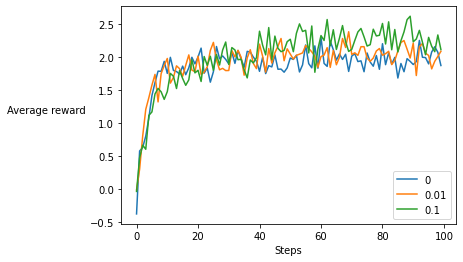

In [16]:
plot_average_rewards([0, 1e-2, 1e-1], n_runs=200, n_steps=100)

In [17]:
def plot_optimal_action_percent(epsilons, n_runs, n_steps):
    """
    Plot a graph of percentage that an optimal action is chosen throughout
    runs for agents specified by their epsilon values. Optimal action is the
    action with highest mean.
    """
    plt.xlabel('Steps')
    plt.ylabel('% Optimal Action', rotation='horizontal', ha='right')
    for epsilon in epsilons:
        env = Environment()
        agent = Agent(env.action_space, epsilon=epsilon)
        _, optimal_action_percent = runs(env, agent, n_runs, n_steps)
        plt.plot(optimal_action_percent)

    plt.legend(epsilons)
    # plt.savefig('plot_optimal_action_percent.png')
    plt.show()

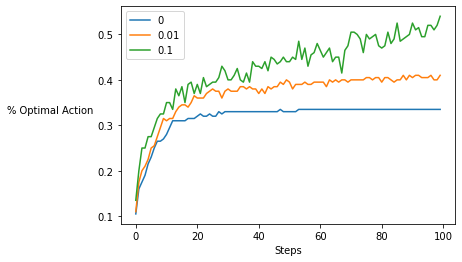

In [18]:
plot_optimal_action_percent([0, 1e-2, 1e-1], n_runs=200, n_steps=100)

In [19]:
def plots(epsilons, n_runs, n_steps):
    """
    Plot two graphs: graph of average reward and graph of optimal action
    percentage.
    """
    f, axarr = plt.subplots(2, sharex=True)
    f.set_figheight(8)
    f.set_figwidth(6)

    axarr[0].set_xlabel('Steps')
    axarr[0].set_ylabel('Average reward', rotation='horizontal', ha='right')
    axarr[1].set_xlabel('Steps')
    axarr[1].set_ylabel('% Optimal Action', rotation='horizontal', ha='right')
    for epsilon in epsilons:
        env = Environment()
        agent = Agent(env.action_space, epsilon=epsilon)
        avg_rewards, optimal_action_percent = runs(env, agent, n_runs, n_steps)
        axarr[0].plot(avg_rewards)
        axarr[1].plot(optimal_action_percent)

    axarr[0].legend(epsilons)
    axarr[1].legend(epsilons)
    # plt.savefig('plots.png')
    plt.show()

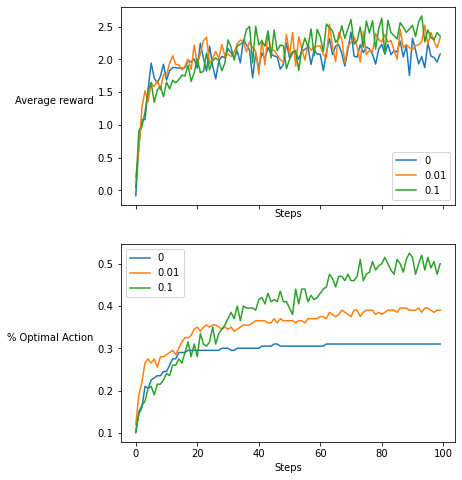

In [20]:
plots([0, 1e-2, 1e-1], n_runs=200, n_steps=100)

## Upper Confidence Bound (UBC)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def argmax_all(list_):
    """
    Returns all argmax of given list in a list. Different from np.argmax which 
    returns first instance only.
    """
    return np.argwhere(list_ == list_.max()).flatten()

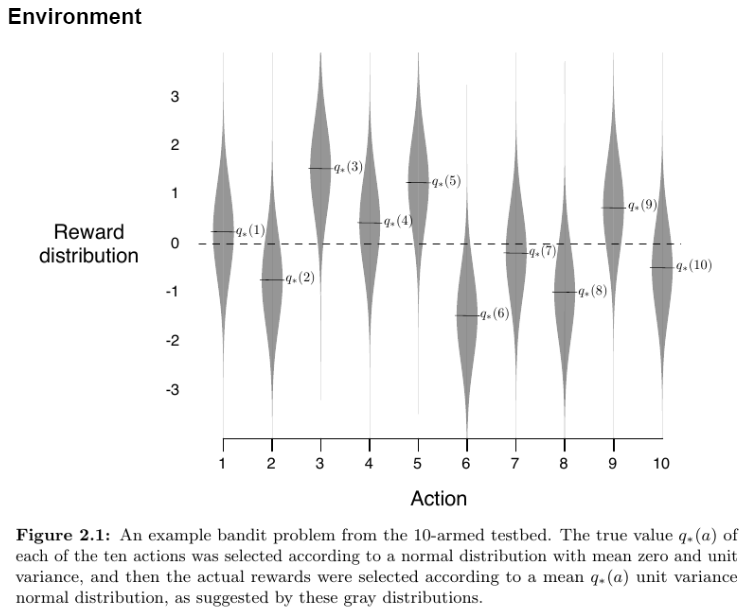

In [23]:
class Environment:
    """
    The 10-armed Testbed environment shown in Figure 2.1 of Sutton and Barto
    """
    def __init__(self, n_actions=10):
        self.action_space = [i for i in range(n_actions)]
        self.distributions = []
        for _ in range(n_actions):
            mean = np.random.normal(0, 1)
            stddev = 1
            self.distributions.append((mean, stddev))

        self.optimal_action = np.argmax([d[0] for d in self.distributions])

    def step(self, action):
        """
        Returns the reward of the given action.
        """
        mean, stddev = self.distributions[action]
        reward = np.random.normal(loc=mean, scale=stddev)
        return reward

    def reset(self):
        """
        Reset the reward distributions of the environment.
        """
        self.distributions = []
        for _ in range(len(self.action_space)):
            mean = np.random.normal(0, 1)
            stddev = 1
            self.distributions.append((mean, stddev))

        self.optimal_action = np.argmax([d[0] for d in self.distributions])

In [24]:
class EpsilonGreedyAgent:
    """
    An e-greedy agent.
    """

    def __init__(self, action_space, epsilon=0, name=None):
        self.action_space = action_space
        self.q = np.zeros(len(action_space))
        self.action_counts = np.zeros(len(action_space), dtype=int)
        self.epsilon = epsilon
        self.name = '$e$ = {}'.format(epsilon) if name is None else name

    def get_action(self):
        """
        Choose action with epsilon-greedy policy.
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            return np.random.choice(argmax_all(self.q))

    def update_q(self, action, reward):
        """
        Update appropriate Q value with given action and reward.
        """
        self.action_counts[action] += 1
        self.q[action] += (reward - self.q[action]) / \
            self.action_counts[action]

    def reset(self):
        """
        Reset agent's Q values to 0.
        """
        self.q = np.zeros(len(self.action_space))
        self.sum_rewards = np.zeros(len(self.action_space))
        self.action_counts = np.zeros(len(self.action_space), dtype=int)

In [25]:
class UCBAgent:
    """
    An Upper Confidence Bound agent.
    """

    def __init__(self, action_space, ucb_c=0, name=None):
        self.action_space = action_space
        self.q = np.zeros(len(action_space))
        self.total_action = 0
        self.action_counts = np.zeros(len(action_space), dtype=int)
        self.ucb_c = ucb_c
        self.name = '$c$ = {}'.format(ucb_c) if name is None else name

    def get_action(self):
        """
        Choose action greedily with UCB action selection.
        """
        ucb_terms = np.zeros(len(self.action_space))
        for action in self.action_space:
            if self.action_counts[action] == 0:
                ucb_terms[action] = float("inf")
            else:
                sqrt_term = np.sqrt(
                    np.log(self.total_action) / self.action_counts[action])
                ucb_terms[action] = (self.ucb_c * sqrt_term)

        best_actions = argmax_all(self.q + ucb_terms)

        return np.random.choice(best_actions)

    def update_q(self, action, reward):
        """
        Update appropriate Q value with given action and reward.
        """
        self.total_action += 1
        self.action_counts[action] += 1
        self.q[action] += (reward - self.q[action]) / \
            self.action_counts[action]

    def reset(self):
        """
        Reset agent's Q values to 0.
        """
        self.q = np.zeros(len(self.action_space))
        self.sum_rewards = np.zeros(len(self.action_space))
        self.action_counts = np.zeros(len(self.action_space), dtype=int)

In [26]:
def run(env, agent, n_steps=1000):
    """
    Take actions on the bandit environment. This is called a "run".
    """
    actions = np.zeros(n_steps, dtype=int)
    rewards = np.zeros(n_steps)
    for i in range(n_steps):
        actions[i] = agent.get_action()
        rewards[i] = env.step(actions[i])
        agent.update_q(actions[i], rewards[i])

    return (actions, rewards)

In [27]:
def runs(env, agent, n_runs=2000, n_steps=1000):
    """
    Perform multiple runs on given environment and agent, resetting
    environment and agent after every run. Resetting environment
    changes the actions' reward distributions, and resetting the
    agent resets its Q values.
    """
    sum_rewards = np.zeros(n_steps)
    optimal_action_counts = np.zeros(n_steps)

    for i in range(n_runs):
        env.reset()
        agent.reset()

        actions, rewards = run(env, agent, n_steps)

        sum_rewards = np.add(sum_rewards, rewards)

    return sum_rewards / n_steps

In [28]:
def plot(agents, n_runs, n_steps):
    """
    Plot a graph of average rewards throughout runs for agents specified by
    their epsilon values.
    """
    plt.xlabel('Steps')
    plt.ylabel('Average reward', rotation='horizontal', ha='right')
    
    names = []
    for agent in agents:
        names.append(agent.name)
        env = Environment()
        avg_rewards = runs(env, agent, n_runs, n_steps)
        plt.plot(avg_rewards)

    plt.legend(names)
    # plt.savefig('plot.png')
    plt.show()

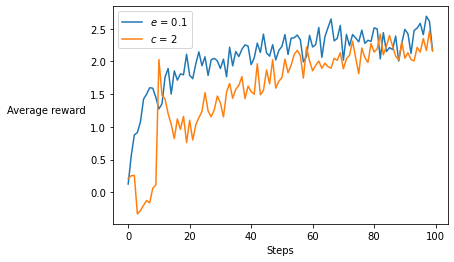

In [29]:
env = Environment()
agents = [
    EpsilonGreedyAgent(env.action_space, epsilon=0.1),
    UCBAgent(env.action_space, ucb_c=2)
]

plot(agents, n_runs=200, n_steps=100)

## Policy Evaluation

In [30]:
from enum import IntEnum
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
class Action(IntEnum):
    """
    All possible actions in a 4x4 gridworld.
    """
    UP = -4
    DOWN = 4
    RIGHT = 1
    LEFT = -1

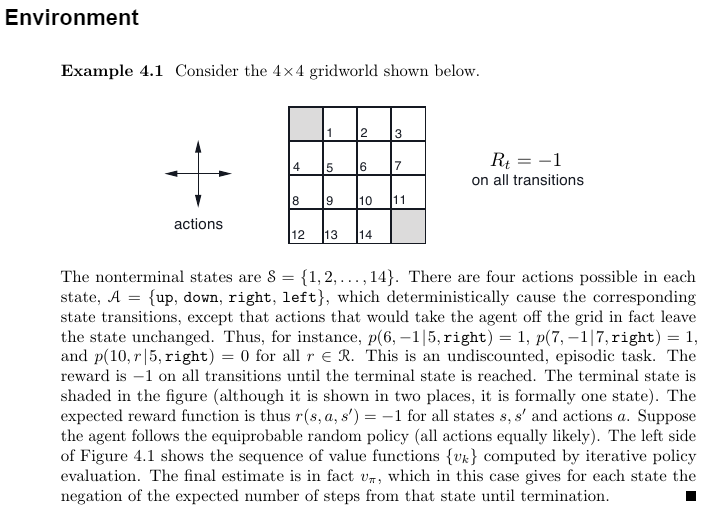

In [32]:
class Environment:
    """
    The 4x4 gridworld shown in Example 4.1.
    """
    state_space = [i for i in range(16)]
    action_space = list(Action)

    def peek(self, state, action):
        """
        Returns the result of taking given action on the given state.
        The result consists of next state and reward.
        """
        if self.is_done(state):
            return state, 0

        if not ((state // 4 == 0 and action == Action.UP)
            or (state // 4 == 3 and action == Action.DOWN)
            or (state % 4 == 3 and action == Action.RIGHT)
            or (state % 4 == 0 and action == Action.LEFT)):
            state += action

        return state, -1

    def is_done(self, state):
        """
        Returns True if given state is the terminal state.
        """
        return state == 0 or state == 15

In [33]:
class RandomAgent:
    """
    A random-policy agent.
    """

    def __init__(self, env):
        self.env = env
        self.v = np.zeros(len(env.state_space))

    def update(self):
        """
        Update agent's state values based on random policy.
        """
        new_v = np.zeros(len(self.env.state_space))
        for state in self.env.state_space:
            for action in self.env.action_space:
                next_state, reward = self.env.peek(state, action)
                new_v[state] += 1/4 * (reward + self.v[next_state])
        self.v = new_v

In [34]:
import tkinter as tk

In [35]:
def keymax(dict_):
    """
    Get list of keys in a dictionary with maximum value.
    """
    max_v = max(dict_.values())
    return [key for key in dict_.keys() if dict_[key] == max_v]

In [36]:
class GUI(tk.Tk):
    """
    GUI for Figure 4.1
    """

    def __init__(self, env, agent, n_steps=500):
        self.env = env
        self.agent = agent

        self.step = 0
        self.cache = []

        # Precompute state values
        for _ in range(n_steps):
            self.cache.append(agent.v)
            agent.update()

        tk.Tk.__init__(self)
        self.canvas = self._build_canvas()
        self._update_canvas()

    def _build_canvas(self):
        """
        Builds a tkinter canvas.
        """
        canvas_w, canvas_h = (480, 300) # Canvas Dimensions
        g1_x, g1_y = (60, 100)          # Center of first square in grid 1
        g2_x, g2_y = (300, 100)         # Center of first square in grid 2
        r = 20                          # Radius of grid cell

        canvas = tk.Canvas(self, width=canvas_w, height=canvas_h, bg='white')

        # Info Text
        self.text_step = canvas.create_text(canvas_w/2, 20)

        # Grid 1
        self.grid1 = []
        for j in range(4):
            for i in range(4):
                x = g1_x + 2*r*i
                y = g1_y + 2*r*j
                canvas.create_rectangle(x-r, y-r, x+r, y+r)
                self.grid1.append({'text': canvas.create_text(x, y)})
                
        # Grid 2
        self.grid2 = []
        for j in range(4):
            for i in range(4):
                cell = {}

                x = g2_x + 2*r*i
                y = g2_y + 2*r*j
                canvas.create_rectangle(x-r, y-r, x+r, y+r)
                cell['text'] = canvas.create_text(x, y)

                cell['arrows'] = {}
                cell['arrows'][Action.UP] = canvas.create_line(
                    x, y, x, y-r, arrow="last")
                cell['arrows'][Action.DOWN] = canvas.create_line(
                    x, y, x, y+r, arrow="last")
                cell['arrows'][Action.LEFT] = canvas.create_line(
                    x, y, x-r, y, arrow="last")
                cell['arrows'][Action.RIGHT] = canvas.create_line(
                    x, y, x+r, y, arrow="last")

                self.grid2.append(cell)

        # Back Button
        back_button = tk.Button(
            self, text="Back", command=self.back_step, width=30, height=3)
        canvas.create_window(canvas_w/4, canvas_h-25, window=back_button)

        # Step Button
        step_button = tk.Button(
            self, text="Evaluate", command=self.run_step, width=30, height=3)
        canvas.create_window(3*canvas_w/4, canvas_h-25, window=step_button)

        canvas.pack(side="top", fill="both", expand=True)

        return canvas

    def run_step(self):
        """
        Updates canvas with state values with one more step of policy
        evaluation.
        """
        if self.step >= len(self.cache) - 1:
            return

        self.step += 1
        self._update_canvas()
              
    def back_step(self):
        """
        Updates canvas with state values with one less step of policy
        evaluation.
        """
        if self.step <= 0:
            return

        self.step -= 1
        self._update_canvas()

    def _update_canvas(self):
        """
        Updates the canvas.
        """
        v = self.cache[self.step]

        # Update Info
        self.canvas.itemconfig(self.text_step, text='k = %d' % self.step)

        # Update V
        for state, value in enumerate(v):
            self.canvas.itemconfig(self.grid1[state]['text'],
                                   text='{:.1f}'.format(v[state]))

        # Update greedy policy
        for state, _ in enumerate(v):
            for action in self.env.action_space:
                self.canvas.itemconfig(self.grid2[state]['arrows'][action],
                                       fill='white')
        for state, value in enumerate(v):
            if state == 0 or state == 15:
                continue

            nearby_values = {}
            for action in self.env.action_space:
                if state == 1 and action == Action.UP:
                    next_state, reward = self.env.peek(state, action)
                next_state, _ = self.env.peek(state, action)

                nearby_values[action] = v[next_state]

            best_actions = keymax(nearby_values)
            for action in best_actions:
                self.canvas.itemconfig(self.grid2[state]['arrows'][action],
                                       fill='black')             
                

In [37]:
env = Environment()
agent = RandomAgent(env)
gui = GUI(env, agent)
gui.mainloop()

## Q-Learning vs State-Action-Reward-State-Action (SARSA)

In [38]:
import copy
from enum import IntEnum
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
def argmax_all(list_):
    """
    Returns all argmax of given list in a list. Different from np.argmax which 
    returns first instance only.
    """
    return np.argwhere(list_ == list_.max()).flatten()

In [40]:
class Action(IntEnum):
    """
    Enum of possible actions in the Cliff environment.
    """
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

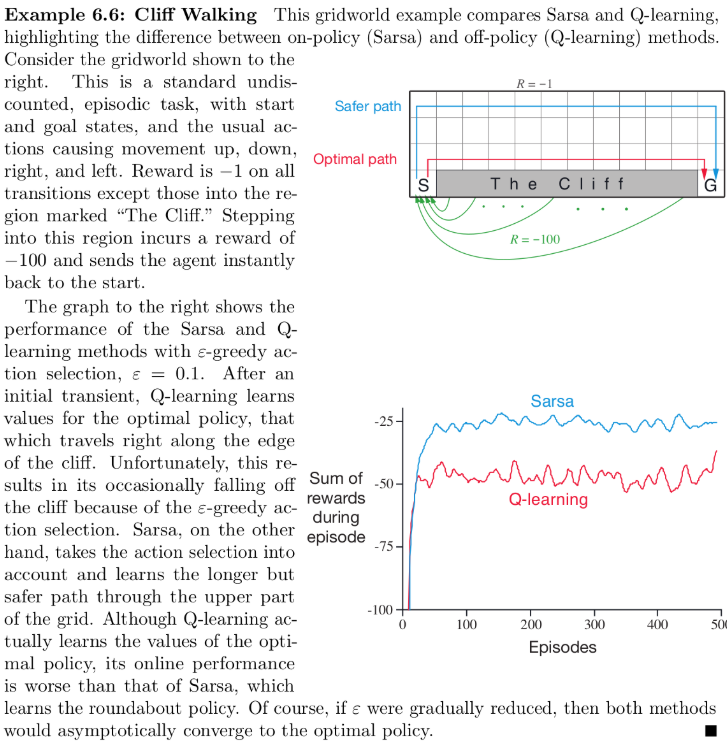

In [41]:
class Environment:
    """
    The Cliff environment shown in Example 6.6.
    """
    action_space = list(map(int, Action))

    def __init__(self, width=12, height=4):
        self.W = width
        self.H = height
        self.state_space = [i for i in range(width * height)]

        self.state = width * (height - 1)

    def _is_goal(self):
        """
        Checks if current state is the goal state.
        """
        return self.state == self.W * self.H - 1

    def _is_cliff(self):
        """
        Checks if current state is a cliff.
        """
        return self.state in range(self.W * (self.H - 1) + 1,
                                   self.W * self.H - 1)

    def reset(self):
        """
        Resets environment and returns initial state.
        """
        self.state = self.W * (self.H - 1)
        return self.state

    def step(self, action):
        """
        Performs given action and returns next_state, reward, done.
        """
        assert action in self.action_space

        if action == Action.LEFT:
            if self.state % self.W > 0:
                self.state -= 1
        elif action == Action.RIGHT:
            if self.state % self.W < self.W - 1:
                self.state += 1
        elif action == Action.UP:
            if self.state // self.W > 0:
                self.state -= self.W
        elif action == Action.DOWN:
            if self.state // self.W < self.H - 1:
                self.state += self.W

        if self._is_cliff():
            reward = -100
            self.state = self.W * (self.H - 1)
        else:
            reward = -1

        done = self._is_goal()

        return self.state, reward, done   

### SARSA

In [42]:
class SarsaAgent:
    def __init__(self,
                 state_space,
                 action_space,
                 epsilon=0.1,
                 learning_rate=0.1,
                 discount_factor=1,
                 name=None):
        """
        Initialize Q table and save environment.
        """
        self.state_space = state_space
        self.action_space = action_space
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.name = 'SARSA' if name is None else name

        self.q_table = np.zeros((len(state_space), len(action_space)),
                                dtype=float)

    def get_action(self, state):
        """
        Returns action based on Q table and epsilon-greedy policy.
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            best_actions = argmax_all(self.q_table[state])
            return np.random.choice(best_actions)

    def update_q(self, state, action, reward, next_state, done):
        """
        Update Q table via SARSA.
        """
        if done:
            target = reward
        else:
            target = reward + self.discount_factor * \
                self.q_table[next_state][self.get_action(next_state)]

        self.q_table[state][action] += self.learning_rate * \
            (target - self.q_table[state][action])

    def reset(self):
        self.q_table = np.zeros((len(env.state_space), len(env.action_space)),
                                dtype=float)

### Q-Learning

In [43]:
class QLearningAgent:
    def __init__(self,
                 state_space,
                 action_space,
                 epsilon=0.1,
                 learning_rate=0.1,
                 discount_factor=1,
                 name=None):
        """
        Initialize Q table and save environment.
        """
        self.state_space = state_space
        self.action_space = action_space
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.name = 'Q-Learning' if name is None else name

        self.q_table = np.zeros((len(state_space), len(action_space)),
                                dtype=float)

    def get_action(self, state):
        """
        Returns action based on Q table and epsilon-greedy policy.
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            best_actions = argmax_all(self.q_table[state])
            return np.random.choice(best_actions)

    def update_q(self, state, action, reward, next_state, done):
        """
        Update Q table via Q-Learning.
        """
        if done:
            target = reward
        else:
            target = reward + self.discount_factor * \
                np.max(self.q_table[next_state])

        self.q_table[state][action] += self.learning_rate * \
            (target - self.q_table[state][action])

    def reset(self):
        self.q_table = np.zeros((len(env.state_space), len(env.action_space)),
                                dtype=float)

In [44]:
def episode(env, agent):
    """
    Run one episode with given environment and agent and return total reward.
    """
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        agent.update_q(state, action, reward, next_state, done)
        state = next_state

        total_reward += reward

    return total_reward

In [45]:
def run(env, agent, n_episodes=500):
    """
    Run multiple episodes with given environment and agent and return list of 
    total rewards for each episode. Agent's Q value persists through episodes.
    """
    total_rewards = np.zeros(n_episodes, dtype=float)
    for i in range(n_episodes):
        env.reset()
        total_rewards[i] = episode(env, agent)

    return total_rewards

In [46]:
def runs(env, agent, n_runs=500, n_episodes=500):
    """
    Perform multiple runs with given environment and agent and return list of 
    average of total rewards for each episode. Agent's Q value persists
    through episodes but is reset after each run.
    """
    total_total_rewards = np.zeros(n_episodes, dtype=float)

    for _ in range(n_runs):
        agent.reset()
        total_total_rewards += run(env, agent, n_episodes)

    return total_total_rewards / n_runs

In [47]:
def plot(env, agents, n_runs=500, n_episodes=500):
    """
    Plots Example 6.6 / Figure 6.4.
    """
    names = []
    for agent in agents:
        names.append(agent.name)
        total_rewards = runs(env, agent, n_runs, n_episodes)
        plt.plot(total_rewards)

    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.legend(names)
    plt.show()

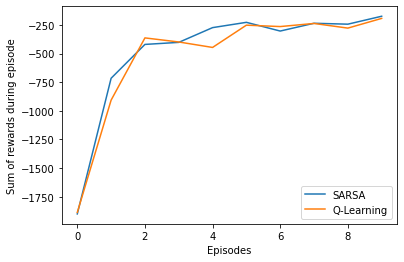

In [48]:
env = Environment()
agents = [
    SarsaAgent(env.state_space, env.action_space),
    QLearningAgent(env.state_space, env.action_space),
]
plot(env, agents, 10, 10)

In [49]:
def draw_policy(env, agent):
    """
    Draws greedy policy of the given agent with arrows.
    """
    print('--------------------------------------------------')
    print(' {}\'s Greedy Policy'.format(agent.name))
    print('--------------------------------------------------')
    for h in range(env.H):
        for w in range(env.W):
            best_action = Action(np.argmax(agent.q_table[h * env.W + w]))
            if best_action == Action.UP:
                print('↑', end=' ')
            elif best_action == Action.DOWN:
                print('↓', end=' ')
            elif best_action == Action.LEFT:
                print('←', end=' ')
            elif best_action == Action.RIGHT:
                print('→', end=' ')
        print()
        print()

In [50]:
env = Environment()
sarsa_agent = agents[0]
q_learning_agent = agents[1]

draw_policy(env, agents[0])
draw_policy(env, agents[1])

--------------------------------------------------
 SARSA's Greedy Policy
--------------------------------------------------
← ← ↑ ← ↑ ← ← ↑ ↓ ← → ← 

↑ → ← ↓ ↑ → → ↑ ↓ → ↓ → 

↑ → → ↑ ↑ → → → → ↑ → → 

↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 

--------------------------------------------------
 Q-Learning's Greedy Policy
--------------------------------------------------
↑ ↓ ↓ → ← ↓ ← ↑ ↑ ↓ → ← 

← → ↑ ↑ → ↓ ↓ ↓ → ↑ ← ← 

↑ ↑ → ↑ → → → ↑ ← → ↑ ↓ 

↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ 

